In [2]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

# Import and split dataset

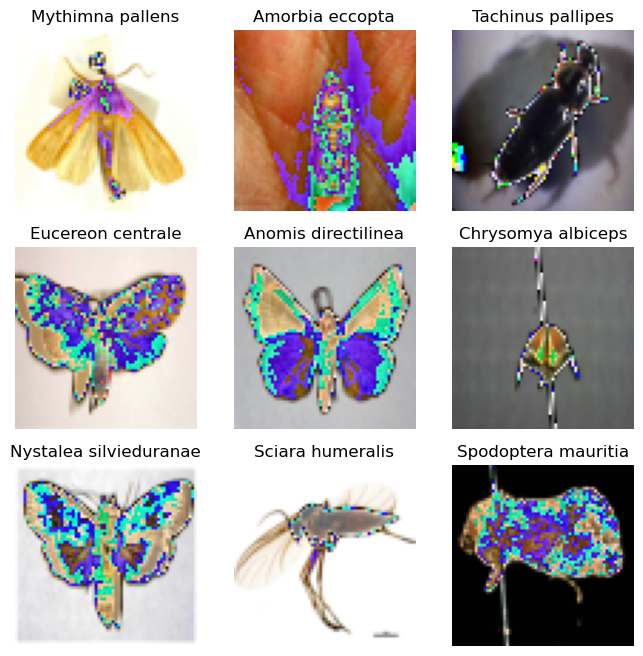

In [3]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [4]:
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_val, X_test, y_train_val, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_val
train_data['species_name'] = y_train_val

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object
32424


32424

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_size = 100 
batch_size =  64

In [12]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


13039
6955
12430


In [13]:
print(y_test.shape)
print(y_train.shape)

(9991,)
(10840,)


In [14]:
# USED TO GENERATE ONLY FAKE IMAGES FROM DESCRIBED SPECIES
described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)

In [39]:
list(image_dataset.class_to_idx.keys())[45]

'Agrotis_ipsilon'

In [37]:
described_species_labels

array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   12,   13,
         15,   16,   18,   19,   21,   22,   23,   26,   29,   30,   32,
         33,   37,   39,   40,   42,   43,   45,   46,   47,   49,   50,
         51,   52,   53,   54,   56,   57,   60,   63,   64,   69,   70,
         73,   74,   75,   76,   77,   78,   79,   80,   82,   83,   84,
         85,   86,   88,   91,   95,   96,   97,   98,  100,  101,  102,
        103,  106,  108,  110,  111,  113,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  126,  127,  131,  132,  134,  135,  136,
        138,  139,  140,  141,  142,  143,  145,  147,  148,  149,  151,
        153,  154,  156,  158,  159,  160,  163,  164,  165,  167,  168,
        170,  171,  172,  173,  174,  177,  178,  180,  181,  182,  184,
        185,  191,  194,  195,  196,  199,  202,  203,  204,  205,  206,
        207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        219,  220,  221,  222,  223,  224,  225,  2

# Initialize and train the models

In [15]:
import os 
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(100, latent_size, 1, 1,device=device)
sample_random_classes = torch.tensor(np.random.randint(0, n_classes, fixed_latent.shape[0]),device=device)

In [16]:
import importlib
import modelC as m
importlib.reload(m)

discriminator = m.Discriminator()
discriminator.cuda()
generator = m.Generator(noise_size=100)
generator.cuda()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),lr=1e-5)
#generator_optimizer = torch.optim.RMSprop(generator.parameters(),lr=1e-5)
generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5, 0.999))


n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


writer = SummaryWriter()

32233243
30220560


In [ ]:
from dataset_utils import Fit_params, Save_samples_params
with torch.no_grad():
    pass
fit_p = Fit_params(discriminator_optimizer,generator_optimizer,discriminator,generator,dataloaders,device,writer,batch_size,n_classes,latent_size,described_species_labels)
save_p = Save_samples_params(fixed_latent,sample_random_classes,sample_dir)
losses_g, losses_d ,real_scores, fake_scores =m.fit(100,fit_p,save_p,start_idx=1)

  0%|          | 0/204 [00:00<?, ?it/s]

/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], loss_g: 1.1890, loss_d: 1.1270, real_score: 0.6471, fake_score: 0.4453
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0001.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 0.9104, loss_d: 1.4962, real_score: 0.4414, fake_score: 0.4064
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0002.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.0623, loss_d: 1.0224, real_score: 0.6435, fake_score: 0.4005
class accuracy real 0.046875
class accuracy fake 0.0
Saving generated-images-0003.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 1.6043, loss_d: 0.9058, real_score: 0.5990, fake_score: 0.3490
class accuracy real 0.0625
class accuracy fake 0.03125
Saving generated-images-0004.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 0.7857, loss_d: 0.9689, real_score: 0.5043, fake_score: 0.2019
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0005.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 2.5898, loss_d: 1.1618, real_score: 0.8012, fake_score: 0.5666
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0006.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.2731, loss_d: 0.6729, real_score: 0.7626, fake_score: 0.3548
class accuracy real 0.09375
class accuracy fake 0.0
Saving generated-images-0007.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.9386, loss_d: 1.2214, real_score: 0.4205, fake_score: 0.2459
class accuracy real 0.046875
class accuracy fake 0.015625
Saving generated-images-0008.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.3051, loss_d: 1.5520, real_score: 0.7984, fake_score: 0.6992
class accuracy real 0.078125
class accuracy fake 0.0
Saving generated-images-0009.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 1.8994, loss_d: 0.7686, real_score: 0.6847, fake_score: 0.3068
class accuracy real 0.0625
class accuracy fake 0.0
Saving generated-images-0010.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 2.0714, loss_d: 0.8548, real_score: 0.7115, fake_score: 0.3797
class accuracy real 0.0625
class accuracy fake 0.0
Saving generated-images-0011.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 1.9552, loss_d: 1.4458, real_score: 0.6899, fake_score: 0.5995
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0012.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 1.5534, loss_d: 0.9886, real_score: 0.6887, fake_score: 0.4440
class accuracy real 0.046875
class accuracy fake 0.03125
Saving generated-images-0013.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.1294, loss_d: 0.7969, real_score: 0.7721, fake_score: 0.4259
class accuracy real 0.078125
class accuracy fake 0.015625
Saving generated-images-0014.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.4367, loss_d: 0.9313, real_score: 0.4739, fake_score: 0.1817
class accuracy real 0.109375
class accuracy fake 0.015625
Saving generated-images-0015.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 1.7396, loss_d: 0.7825, real_score: 0.7944, fake_score: 0.4160
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0016.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 1.5449, loss_d: 1.1757, real_score: 0.6991, fake_score: 0.5091
class accuracy real 0.03125
class accuracy fake 0.0
Saving generated-images-0017.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 1.2082, loss_d: 1.5224, real_score: 0.5879, fake_score: 0.5535
class accuracy real 0.0625
class accuracy fake 0.0
Saving generated-images-0018.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 1.3382, loss_d: 1.0179, real_score: 0.4897, fake_score: 0.2176
class accuracy real 0.09375
class accuracy fake 0.0
Saving generated-images-0019.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.9014, loss_d: 0.7987, real_score: 0.6959, fake_score: 0.4365
class accuracy real 0.15625
class accuracy fake 0.03125
Saving generated-images-0020.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.4036, loss_d: 0.8524, real_score: 0.6315, fake_score: 0.3479
class accuracy real 0.09375
class accuracy fake 0.015625
Saving generated-images-0021.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.3529, loss_d: 1.0398, real_score: 0.5129, fake_score: 0.2702
class accuracy real 0.09375
class accuracy fake 0.015625
Saving generated-images-0022.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.0037, loss_d: 0.8170, real_score: 0.6770, fake_score: 0.3703
class accuracy real 0.0625
class accuracy fake 0.03125
Saving generated-images-0023.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.2613, loss_d: 1.2666, real_score: 0.7077, fake_score: 0.5549
class accuracy real 0.046875
class accuracy fake 0.015625
Saving generated-images-0024.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 1.6363, loss_d: 1.0902, real_score: 0.6160, fake_score: 0.4309
class accuracy real 0.046875
class accuracy fake 0.015625
Saving generated-images-0025.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 1.4773, loss_d: 0.7424, real_score: 0.6477, fake_score: 0.2755
class accuracy real 0.078125
class accuracy fake 0.015625
Saving generated-images-0026.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 1.6388, loss_d: 1.3538, real_score: 0.8462, fake_score: 0.6729
class accuracy real 0.0625
class accuracy fake 0.015625
Saving generated-images-0027.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 1.4292, loss_d: 0.9207, real_score: 0.6759, fake_score: 0.4284
class accuracy real 0.078125
class accuracy fake 0.046875
Saving generated-images-0028.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 1.2969, loss_d: 0.9559, real_score: 0.6453, fake_score: 0.4315
class accuracy real 0.0625
class accuracy fake 0.078125
Saving generated-images-0029.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 1.7894, loss_d: 1.3892, real_score: 0.7157, fake_score: 0.6095
class accuracy real 0.0625
class accuracy fake 0.03125
Saving generated-images-0030.png


  0%|          | 0/204 [00:00<?, ?it/s]

In [ ]:

dataset_utils.species_label_to_genus_label()

# Altra roba

In [19]:
raise Exception
torch.save({
            'epoch':100,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/generatorC")
torch.save({
            'epoch': 100,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/discriminatorC")

In [ ]:
image_dataset.class_to_idx['Hemiceras_nigrescens']

In [ ]:
image_dataset.class_to_idx['Abax_parallelepipedus']

In [ ]:
raise Exception
fixed_latent2 = torch.randn(1, latent_size, 1, 1,device=device)

for class_fix in range(len(image_dataset.class_to_idx)):
    random_classes = torch.tensor(np.random.randint(class_fix, class_fix+1, fixed_latent2.shape[0]),device=device)
    print(random_classes)
    specie_name = list(image_dataset.class_to_idx.keys())[class_fix]
    specie_name_no_underscore= specie_name.replace("_"," ")
    if specie_name_no_underscore in list(X_train['species_name']):
        fake_images = generator(fixed_latent2,random_classes)
        fake_fname = f'{specie_name}.png'
        save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        #writer.add_image('sample image',denorm(fake_images[0]),global_step=index)
        print('Saving', fake_fname)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    

In [ ]:
'Nola cucllatella' in list(X_train['species_name'])

In [ ]:
X_train['species_name']

In [ ]:

ct = nn.ConvTranspose2d( 100+embedding_size, 64 * 8, 4, 1, 0, bias=False)

In [ ]:
i = torch.ones(32,1100,1,1)

In [ ]:
x = ct(i)
print(x.shape)
up = nn.Upsample(scale_factor=2, mode='bilinear')
x = up(x)
print(x.shape)
conv1 = nn.Conv2d(64*8,64*8,1)
x = conv1(x)
print(x.shape)
x = up(x)
print(x.shape)
conv2 = nn.Conv2d(64*8,64*4,1)
x = conv2(x)
print(x.shape)
x = up(x)
print(x.shape)
conv3 = nn.Conv2d(64*4,64*2,1)
x = conv3(x)
print(x.shape)
x = up(x)
print(x.shape)
conv4 = nn.Conv2d(64*2,64*1,1)
x = conv4(x)
print(x.shape)
x = up(x)
print(x.shape)
conv5 = nn.Conv2d(64*1,3,1)
x = conv5(x)
print(x.shape)
x = up(x)
print(x.shape)

In [ ]:
a = torch.eye(2,3)
a[0][0]=2
a[0][1]=3
a

In [ ]:
a.mean(1)

In [ ]:
a.shape